## XQ1i interactive UI

This notebook guides the user through the calibration and control of two qubits (QBs) within the XQ1i quantum processor:
- QB1: NV electron spin
- QB2: nitrogen ($^{14}$N) nuclear spin

The first notebook cell imports the xq1i library (`libxq1i`) along with some other python modules to establish the communication to and initialization of the device. During initialization, the last saved calibration parameters are loaded from the hard drive (contained in the subfolder `calib_params`). In case the loaded calibration parameters are deemed to be outdated, a warning is printed. In such a case re-running the calibration cell is recommended.

In [3]:
import time
import datetime
import os
import json
import numpy as np
import matplotlib.pyplot as plt

import importlib
import libxq1i
importlib.reload(libxq1i)

try: 
   pulsed_master_logic
except NameError:
   manager.startModule('logic', 'pulsed_master_logic')

xq1i = libxq1i.xq1i(pulsed_master_logic, pulsed_measurement_logic, sequence_generator_logic)

INFO: loaded calibration parameters from file 'calib_params_20240424_1350.json'


## Calibration cell
The following notebook cell performs the calibration of the two-qubit system by determining the resonance frequencies of the relevant state transitions and their driving periods.

In [4]:
#Measure Qubit-1 transition frequency#
res_freq = 1.448466e9
xq1i.generate_params['microwave_frequency'] = res_freq
xq1i.pulsedODMR_params['freq_start'] = res_freq - 5.0e6
xq1i.pulsedODMR_params['freq_step'] = 0.1e6
xq1i.pulsedODMR_sweeps = 80000 
xq1i.do_pulsedODMR()
time.sleep(2)
result_dict = xq1i.pulsed_measurement_logic.do_fit('Lorentzian Dip')
xq1i.calib_params['res_freq'] = float(result_dict.params['center'].value)
time.sleep(2)

#Measure Qubit-1 gate parameters#
xq1i.rabi_sweeps = 80000
xq1i.do_rabi(isSlow=False)    # perform fast Rabi
result_dict = xq1i.pulsed_measurement_logic.do_fit('Sine')
xq1i.calib_params['rabi_period_HighPower'] = float(1/(result_dict.params['frequency'].value))
xq1i.generate_params['rabi_period'] = xq1i.calib_params['rabi_period_HighPower']
xq1i.pulsed_master_logic.set_generation_parameters(xq1i.generate_params)
#xq1i.pulsed_measurement_logic.do_fit('No Fit')
time.sleep(2)

In [ ]:
#Measure Qubit-2 transition frequency m_s=0#
xq1i.nucspect_params['NV_pi'] = False
xq1i.nucspect_params['freq_start'] = 5.05e6
xq1i.nucspect_sweeps = 80000
xq1i.do_Nucspect()
time.sleep(2)    
result_dict = xq1i.pulsed_measurement_logic.do_fit('Lorentzian Dip')
xq1i.calib_params['RF_freq0'] = float(result_dict.params['center'].value)

#Measure Qubit-2 gate parameters m_s=0#
xq1i.nucrabi_params['NV_pi'] = False
xq1i.nucrabi_sweeps = 80000
xq1i.do_NucRabi()
result_dict = xq1i.pulsed_measurement_logic.do_fit('Sine')
xq1i.calib_params['nucrabi_RFfreq0_period'] = float(1/(result_dict.params['frequency'].value))

#Measure Qubit-2 transition frequency m_s=1#
xq1i.nucspect_params['NV_pi'] = True
xq1i.nucspect_params['freq_start'] = 2.90e6
xq1i.nucspect_sweeps = 80000
xq1i.do_Nucspect()
time.sleep(2)    
result_dict = xq1i.pulsed_measurement_logic.do_fit('Lorentzian Dip')
xq1i.calib_params['RF_freq1'] = float(result_dict.params['center'].value)

#Measure Qubit-2 gate parameters m_s=1#
xq1i.nucrabi_params['NV_pi'] = True
xq1i.nucrabi_sweeps = 80000
xq1i.do_NucRabi()
result_dict = xq1i.pulsed_measurement_logic.do_fit('Sine')
xq1i.calib_params['nucrabi_RFfreq1_period'] = float(1/(result_dict.params['frequency'].value))

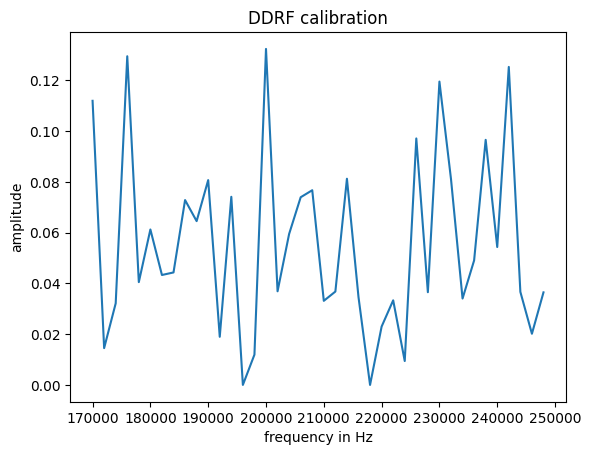

In [8]:
 # #DDRF transition frequency measurement
outfile = open("./14N_Calibration/DDRFamplist_freq_{:.0f}.txt".format(xq1i.DDrfspect_params['freq']), "w")
DDRFamplist = []
freqls = np.arange(170e3,250e3,2e3).tolist()
for freq in freqls:
    xq1i.DDrfspect_params['RF_freq'] = freq
    xq1i.DDrfspect_sweeps = 20000
    xq1i.do_DDrf_Spect()
    result_dict = xq1i.pulsed_measurement_logic.do_fit('Sine_Fixed_Freq_360')
    amplitude = float(result_dict.params['amplitude'].value)
    DDRFamplist.append([freq,amplitude])
    outfile.write("{:.15f}\t{:.15f}\n".format(freq, amplitude))
    outfile.flush()
    time.sleep(2)
outfile.close()
fig = plt.figure()
ax = plt.axes()
ax.set_title('DDRF calibration')
ax.set_xlabel('frequency in Hz')
ax.set_ylabel('amplitude')
DDRFampArray = np.array(DDRFamplist)
ax.plot(DDRFampArray[:,0], DDRFampArray[:,1])
plt.show()

In [8]:
#Measure Qubit-1 transition frequency#
res_freq = 1.449466e9
xq1i.generate_params['microwave_frequency'] = res_freq
xq1i.pulsedODMR_params['freq_start'] = res_freq - 5.0e6
xq1i.pulsedODMR_params['freq_step'] = 0.1e6
xq1i.pulsedODMR_sweeps = 80000 
xq1i.do_pulsedODMR()
time.sleep(2)
result_dict = xq1i.pulsed_measurement_logic.do_fit('Lorentzian Dip')
xq1i.calib_params['res_freq'] = float(result_dict.params['center'].value)
time.sleep(2)

#calibration of CnNOTe (if nuclear spin in state 0, electron spin is flipped)#
xq1i.rabi_sweeps = 80000
xq1i.do_rabi(isSlow=True)    # perform slow Rabi
result_dict = xq1i.pulsed_measurement_logic.do_fit('Sine')
xq1i.calib_params['rabi_period_LowPower'] = float(1/(result_dict.params['frequency'].value))
xq1i.calib_params['rabi_offset'] = float(result_dict.params['offset'].value)
xq1i.calib_params['rabi_amplitude'] = abs(float(result_dict.params['amplitude'].value))
xq1i.saveCalibParams()
time.sleep(2)

## Quantum circuit execution
The next cell defines a quantum circuit for the calibrated two-qubit system, executes it, and outputs the measured final populations of the four computational basis states. 
The compuatational basis states are:
- `00`: $|0\rangle_\textrm{el} \otimes |0\rangle_\textrm{14N}$
- `01`: $|0\rangle_\textrm{el} \otimes |1\rangle_\textrm{14N}$
- `10`: $|1\rangle_\textrm{el} \otimes |0\rangle_\textrm{14N}$
- `11`: $|1\rangle_\textrm{el} \otimes |1\rangle_\textrm{14N}$

Any of the computational basis states can be chosen as the initial state of the circuit.

The quantum circuit is defined as a list of native gates. Each gate of the circuit takes the following parameters:
- gate name
- qubit acted upon
- optional gate parameter (only relvant for some gates, see list of native gates below)

The following native gates are available
- `sx(n)`: $\sqrt{X}$, performs a $\pi/2$ rotation on qubit $n$ ($n \in [1,2]$) along the x-axis of the Bloch sphere
- `rz(n)[theta]`: $R_z(\theta)$, performs a rotation by angle $\theta$ along the z-axis on qubit $n$ ($n \in [1,2]$), where $\theta$ is provided as optional gate parameter (unit: degrees)
- `noop[t_delay]`: delays the execution of all subsequent gates in the circuit by a duration $t_\mathrm{delay} \geq 0$, where $t_\mathrm{delay}$ is provided as optional gate parameter (unit: seconds)
- `c0x(n)`: controlled NOT of qubit $n$ ($n \in [1,2]$) if the control qubit is in state 0
- `c1x(n)`: controlled NOT of qubit $n$ ($n \in [2]$) if the control qubit is in state 1

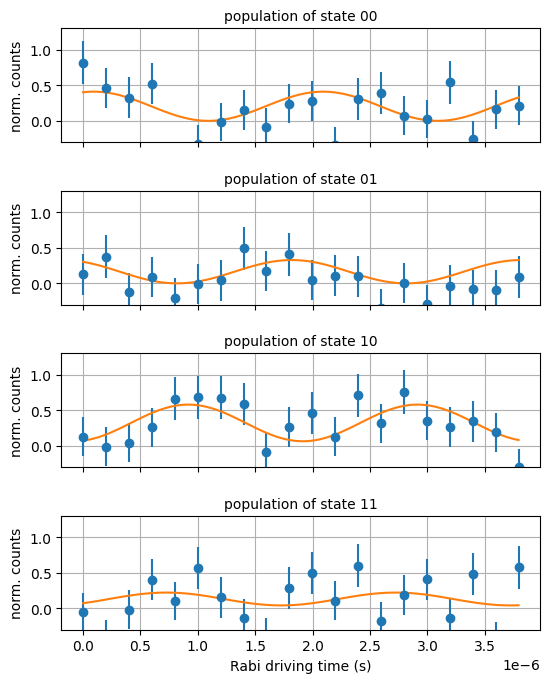

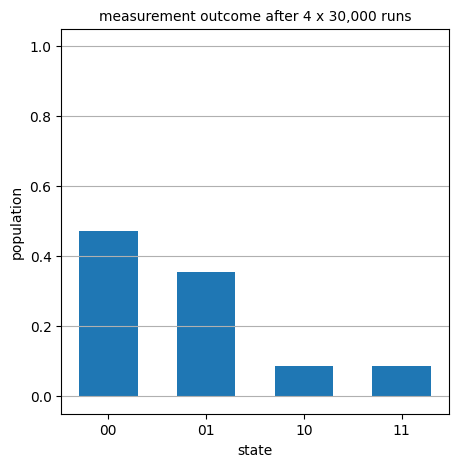

In [5]:
xq1i.QCQB12_params['Initial_state'] = libxq1i.TQstates.State00
xq1i.QCQB12_sweeps = 30e3
qcQB12 = [
     xq1i.gate("noop", param=100.0e-9),
     #xq1i.gate("sx", 1),
     #xq1i.gate("sx", 1),
     #xq1i.gate("c0x", 2),
     #xq1i.gate("c0x", 1),
]

populations = {}
fig, axs = plt.subplots(len(libxq1i.TQstates), 1, sharex=True, figsize=(6,7))
fig.tight_layout(pad=2.5)
for readState,ax in zip(libxq1i.TQstates,axs):
    xq1i.QCQB12_params['Readout_state'] = readState
    xq1i.do_QuantumCircuitQB12(qcQB12)
    tData = libxq1i.covertNetrefToNumpyArray(pulsed_measurement_logic.signal_data[0])
    sigData =  xq1i.getPopulationFromCounts( libxq1i.covertNetrefToNumpyArray(pulsed_measurement_logic.signal_data[1]) )
    errData = libxq1i.covertNetrefToNumpyArray(pulsed_measurement_logic.measurement_error[1]) / (2*xq1i.calib_params['rabi_amplitude'])
    result_dict = xq1i.pulsed_measurement_logic.do_fit('Sine')
    tFit,sigFit = xq1i.getFitFromNormalizedCounts(tData, sigData)
    populations[readState.value] = sigFit[0]
    ax.errorbar(tData, sigData, yerr=errData, fmt='o')
    ax.plot(tFit, sigFit)
    ax.grid()
    ax.set_ylim([-0.3, 1.3])
    ax.set_title(f'population of state {readState.value}', fontsize = 10)
    ax.set_ylabel('norm. counts')
plt.xlabel('Rabi driving time (s)')    
plt.show()


sumPopulations = np.sum(list(populations.values()))
for state in populations:
    populations[state] /= sumPopulations
xq1i.saveMeasurementResult( [{'QCQB12_sweeps': xq1i.QCQB12_sweeps}, populations] )

plt.figure(figsize=(5,5))
plt.bar(populations.keys(), populations.values(), width=0.6)
plt.grid(axis='y')
plt.ylim( (-0.05, 1.05) )
plt.title(f'measurement outcome after {len(populations)} x {xq1i.QCQB12_sweeps:,.0f} runs', fontsize=10)
plt.xlabel('state')
plt.ylabel('population')
plt.savefig(xq1i.measResFilePrefix + f"{datetime.datetime.now().strftime('%Y%m%d_%H%M')}.pdf", bbox_inches='tight')
plt.show()

# countsDark = xq1i.calib_params['rabi_offset'] - xq1i.calib_params['rabi_amplitude']
# raw_populations = np.array( [(float(ppl)-countsDark)/(2*xq1i.calib_params['rabi_amplitude']) for ppl in pulsed_measurement_logic.signal_data[1]] )
# populations = (1 - np.sum(raw_populations))/4 + raw_populations

# fig, ax = plt.subplots()
# ax.bar(['00', '01', '10', '11'], populations,
#        yerr = [float(err)/(2*xq1i.calib_params['rabi_amplitude']) for err in pulsed_measurement_logic.measurement_error[1]],
#        width=0.6)
# ax.set_xlabel('state')
# ax.set_ylabel('population')
# ax.set_ylim( (-0.3, 1.1) )
# plt.show()

In [ ]:
from qudi.logic.pulsed.predefined_generate_methods.qubit_control_methods import Gates
from enum import Enum

def isEnumMember(enum, nameElemCandidate):
    for elem in enum:
        if elem.name == nameElemCandidate:
            return True
    return False

circ_gates = [Gates.NOOP, Gates.ucq1Sqrtz, Gates.CnNOTe]
gate_operations = ", ".join([gate.name for gate in circ_gates])
print(gate_operations)
oper_list = [Gates[oper].name for oper in gate_operations.replace(" ", "").split(",")]
print(oper_list)

for oper in oper_list:
    print(isEnumMember(Gates, oper))

myCirc = [ s
    xq1i.gate("sx", 1), 
    xq1i.gate("rz", 2, param=90),
    xq1i.gate("sx", 2),
    xq1i.gate("c0x", 2),
    xq1i.gate("rz", 1, param=90),
    xq1i.gate("c1x", 2),
    xq1i.gate("c0x", 1)
]
myCircStringRepr = ", ".join([f"{gate.name}({gate.param})[{gate.qubit}]"  for gate in myCirc])
print(myCircStringRepr)